In [31]:
%load_ext autoreload
%autoreload 2
import os
import pystan
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from __future__ import division
# import ite
from tqdm import tqdm_notebook
import re
import glob
import tensorflow as tf
from tensorflow.contrib import slim
ds = tf.contrib.distributions
# st = tf.contrib.bayesflow.stochastic_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Parameters
batch_size = 512
data = {'J': 8,
        'y': [2.8,  0.8, -0.3,  0.7, -0.1,  0.1, 1.8, 1.2],
       'sigma': [0.8, 0.5, 0.8, 0.6,  0.5, .6, 0.5, 0.4],
       'psigma_eta': 1., 'psigma_mu': 1., 'psigma_tau': 1.}



In [33]:
def kde(mu, tau, bbox=[-5, 5, -5, 5], xlabel="", ylabel=""):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(1.0*4/5*abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xx, yy = np.mgrid[bbox[0]:bbox[1]:100j, bbox[2]:bbox[3]:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap='Blues')

    plt.show()

def scatter(mu, tau, bbox=[-5, 5, -5, 5], xlabel="", ylabel=""):
    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(1.0*4/5*abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
                        
    ax.scatter(mu, tau, edgecolor='none', alpha=0.5)

    plt.show()    

    
def hist(x, xlabel="", ylabel=""):
    fig, ax = plt.subplots()
    ax.hist(x, bins=50)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
    
def heat_map(f, bbox=[-5, 5, -5, 5], xlabel="", ylabel=""):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    N, M = f.shape
    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
                        
    xx, yy = np.mgrid[bbox[0]:bbox[1]:(N*1j), bbox[2]:bbox[3]:(M*1j)]
    cfset = ax.contourf(xx, yy, f, cmap='Reds')
    cset = ax.contour(xx, yy, f, colors='k')
    plt.show()

def heat_map_func(func, data, bbox=[-5, 5, -5, 5], **kwargs):
    xx, yy = np.mgrid[bbox[0]:bbox[1]:100j, bbox[2]:bbox[3]:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(func(positions, data=data).T, xx.shape)
    heat_map(f, bbox, **kwargs)

In [34]:
#pot1
param_dim = 1
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1
def pot1(z,data):
    z = tf.transpose(z)
    ans=.5*((tf.norm(z, ord=2, axis=0)-3.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-3.)/.6)**2) + tf.exp(-.5*((z[0]+3.)/.6)**2))
    return -ans
def pot2(z,data):
    z = tf.transpose(z)
    ans=.5*((z[1]-w1(z))/.4)**2
    return -ans

def pot2_(z):
    z = tf.transpose(z)
    ans=.5*((z[1]-w1(z))/.4)**2
    return -ans

def pot3(z,data):
    z = tf.transpose(z)
    ans=-tf.log(tf.exp(-.5*((z[1]-w1(z))/.35)**2) + tf.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
    return -ans
def pot4(z,data):
    z = tf.transpose(z)
    ans=-tf.log(tf.exp(-.5*((z[1]-w1(z))/.4)**2) + tf.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))
    return -ans

def pot6(z):
    z = tf.transpose(z)
    ans=.5*((tf.maximum(z[1],0.0)-w1(z))/.4)**2   
    return -ans


num_mixtures =2
radius = 0.5
thetas = np.linspace(0, 2 * np.pi, num_mixtures + 1)[:num_mixtures]
xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
means_x = list([np.array([a,b]) for a,b in zip(xs,ys)])
std = 0.02
u_mean=tuple(zip(xs, ys))
u_cov=tuple([(std, std)] * num_mixtures)
def pot5(x,data):
        ds = tf.contrib.distributions
        mix = 0.5
        gauss_ref = ds.Mixture(
          cat=ds.Categorical(probs=[mix, 1.-mix]),
          components=[
            ds.MultivariateNormalDiag(loc=u_mean[0], scale_diag=u_cov[0]),
            ds.MultivariateNormalDiag(loc=u_mean[1], scale_diag=u_cov[1]),
        ])
                    
        return gauss_ref.log_prob(x)


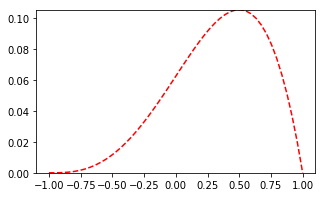

In [35]:
# plot the Target distribution

range_limit = [-1,1]
npoints_plot=50

def evaluate_bivariate(range, npoints):
    """Evaluate (possibly unnormalized) pdf over a meshgrid."""
    side = np.linspace(range[0], range[1], npoints)
    z1, z2 = np.meshgrid(side, side)
    zv = np.hstack([z1.reshape(-1, 1), z2.reshape(-1, 1)])
    return z1, z2, zv


z_pp  = tf.placeholder(tf.float32, [None,])
prob = tf.maximum( (1- (z_pp/2.0 + 0.5) )*(z_pp/2.0 + 0.5) **(3.0), 0.0 )# tf.maximum(tf.exp(-z_pp)*z_pp, 0.0)


fig, _ = plt.subplots(figsize=(5, 3))
# ax=plt.subplot(1,1,1, aspect='equal')
coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)

with tf.Session() as s:
    phat_z = s.run(prob, feed_dict={z_pp: coords} ) 
plt.plot(coords, phat_z, 'r--')
z_min, z_max = -np.abs(phat_z).max(), np.abs(phat_z).max()
plt.ylim(0.0,z_max)
# plt.pcolor(mesh_z1, mesh_z2, phat_z, cmap='RdBu', vmin=z_min, vmax=z_max)
# plt.xlim(range_limit); plt.ylim(range_limit); ax.set_title('Target distribution: $u(z)$')
plt.show()

In [40]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def standard_normal(shape, **kwargs):
    """Create a standard Normal StochasticTensor."""
    return st.StochasticTensor(
        ds.MultivariateNormalDiag(loc=tf.zeros(shape), scale_diag=tf.ones(shape), **kwargs))

def posterior(reuse=False):
    with tf.variable_scope("posterior", reuse=reuse) as scope:
        # eps = standard_normal([batch_size, param_dim]).value()
        
        Normal = tf.distributions.Normal(loc=tf.zeros(param_dim), scale=tf.ones(param_dim))
        eps = Normal.sample([batch_size])
        
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.elu):
            net = slim.fully_connected(eps, 128, scope='fc_0')
            net = slim.fully_connected(net, 128, scope='fc_1')
#             net = slim.fully_connected(net, 128, scope='fc_2')
                
        z = slim.fully_connected(net, param_dim, activation_fn=tf.nn.tanh, scope='z')
        return z

def auxiliary(reuse=False):
    with tf.variable_scope("auxiliary", reuse=reuse) as scope:
        # eps = standard_normal([batch_size, param_dim]).value()
        
        Normal = tf.distributions.Normal(loc=tf.zeros(param_dim), scale=tf.ones(param_dim))
        eps = Normal.sample([batch_size])
        
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.elu):
            net = slim.fully_connected(eps, 128, scope='fc_0')
            net = slim.fully_connected(net, 128, scope='fc_1')
#             net = slim.fully_connected(net, 128, scope='fc_2')
                
        z = slim.fully_connected(net, param_dim, activation_fn=tf.nn.tanh, scope='z')
        return z

    
def adversary(z, reuse=False):
    with tf.variable_scope("adversary", reuse=reuse) as scope:
        with slim.arg_scope([slim.fully_connected], activation_fn=lrelu):
            net = slim.fully_connected(z, 256, scope='fc_0')

            for i in range(5):
                dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

        T = slim.fully_connected(net, 1, activation_fn=None, scope='T',
                                weights_initializer=tf.constant_initializer(0.))
        T = tf.squeeze(T, [1])
        return T

In [44]:
# Parameter for AVB: wether to use adaptive contrast
is_adapt_contrast = True
tf.reset_default_graph() 
z0 = tf.random_normal([batch_size, param_dim], name="z0")
z_ = posterior()
beta = tf.constant(1.)

if is_adapt_contrast:
    Ez_, Varz_ = tf.nn.moments(z_, [0], keep_dims=True)
    stdz_ = tf.sqrt(Varz_) + 1e-6
    Ez_ = tf.stop_gradient(Ez_)
    stdz_ = tf.stop_gradient(stdz_)

    zr = Ez_ + stdz_ * z0
    znorm_ = (z_ - Ez_) / stdz_

gauss_ref = ds.MultivariateNormalDiag(loc=[0, 0.], scale_diag=[1.0, 1.0])

#################### Gamma Reference for constrined domain 

# dist_gamma = tf.distributions.Gamma(concentration=3.0, rate=2.0)

    
if is_adapt_contrast:
    print('using AC')
    logr_      = gauss_ref.log_prob(znorm_)
    Ti = adversary(z0)
    Td = adversary(znorm_, reuse=True)
else:
    logr_=gauss_ref.log_prob(z_)
    Ti = adversary(z0)
    Td = adversary(z_, reuse=True) 
    
    
# prob = tf.maximum(tf.exp(-z_[:,0])*z_[:,0] + tf.exp(-z_[:,1])*z_[:,1], 0.0)
prob = tf.maximum( (1- (z_/2.0 + 0.5) )*(z_/2.0 + 0.5) **(3.0), 0.0 )
logprob = tf.log(prob) # get_logprob(z_, data)


mean_logprob = tf.reduce_mean(logprob)
mean_Td = tf.reduce_mean(Td)
loss_primal = tf.reduce_mean(beta*(logr_ + Td) - logprob)

d_loss_d = tf.reduce_mean(
   tf.nn.sigmoid_cross_entropy_with_logits(logits=Td, labels=tf.ones_like(Td))
)
d_loss_i = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Ti, labels=tf.zeros_like(Ti))
)
loss_dual = d_loss_i + d_loss_d

using AC


In [45]:
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "posterior")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "adversary")
popt = tf.train.AdamOptimizer(1e-4, beta1=0.5)
dopt = tf.train.AdamOptimizer(2e-4, beta1=0.5)

grads_primal =  popt.compute_gradients(loss_primal, var_list=pvars)
grads_dual = dopt.compute_gradients(loss_dual, var_list=dvars)

train_primal = popt.apply_gradients(grads_primal)
train_dual = dopt.apply_gradients(grads_dual)

train_step = [train_primal, train_dual]

In [47]:
from tqdm import tqdm_notebook, tnrange

def run_training(sess, data, niter=10000, betas=None, npretrain=0):       
    if betas is None:
        betas = []
        
    for i in tnrange(npretrain, desc="Pretrain"):
        sess.run(train_dual)

    pbar = tnrange(niter+1, desc="Train")
    for i in pbar:
        if i >= np.size(betas):
            beta_i = 1.
        else:
            beta_i = betas[i]
                           
        _, lp, ld, td = sess.run(
                [train_primal, loss_primal, loss_dual, mean_Td],
                feed_dict={beta: beta_i}
        )
        
        sess.run(train_dual)
        sess.run(train_dual)
            
        pbar.set_description("lp=%.3f, ld=%.3f, td=%.3f"  % (lp, ld, td))

def get_samples(sess, nbatches=100):
    zs = np.zeros([nbatches, batch_size, param_dim])
    for i in range(nbatches):
        zs[i] = sess.run(z_)
    zs = zs.reshape(-1, param_dim)
    return zs

# def stan_vb(stan_vb_alg="fullrank", niter=10000):
#     stan_vb_out = "./vb.out"
#     sm.vb(data=data, sample_file=stan_vb_out, algorithm=stan_vb_alg, iter=niter, output_samples=10000, seed=1)
#     stan_vb_samples = np.genfromtxt(stan_vb_out, dtype=float, delimiter=',')
#     stan_vb_samples = stan_vb_samples[1:, 1:param_dim+1]

#     return stan_vb_samples

In [48]:
# Close existing session if available
try:
    sess.close()
except NameError:
    pass
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [49]:
# Some parameters for the model fitting
iter_max = 20000
# AVB
run_training(sess, data, niter=iter_max, npretrain=0)

HBox(children=(IntProgress(value=1, bar_style=u'info', description=u'Pretrain: ', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Train: ', max=20001), HTML(value=u'')))

In [50]:
# Parameters for visualization
idx0, idx1 = 0, 1
labels = [r'$x$', r'$u(x)$', r'$\eta_1$']
xlabel = labels[idx0]
ylabel = labels[idx1]


In [51]:
q = get_samples(sess, nbatches=500)
np.save('AC_Gaussian_constrained',q)

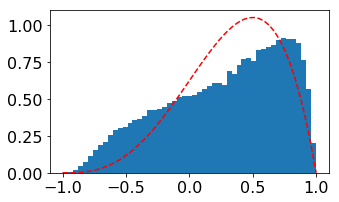

In [73]:
q = get_samples(sess, nbatches=200)
q1 = q[:, idx0]

fig, _ = plt.subplots(figsize=(5, 3))
plt.rc('font', size=16)
plt.hist(q1, 50, normed=1)

from scipy.stats import beta

plt.plot(coords, beta.pdf(coords/2.0 + 0.5, 4, 2)/2.0, 'r--')
plt.show()

    